# Source of the notebook
This notebook is part of the basic tutorial of the "particle" packages, available at https://particles-sequential-monte-carlo-in-python.readthedocs.io/en/latest/notebooks/basic_tutorial.html . It is here to be help the team get used to the package, but we are not the authors of this notebook. 
The whole package can be found on github at : https://github.com/nchopin/particles. 

# Importations

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sb

# Modules from particles
import particles 
from particles import distributions as dists # Where proba distributions are defined
from particles import state_space_models as ssm # Where state-space-models are defined
from particles.collectors import Moments

# Définition d'un modèle de base
Volatilité stochastique 

In [2]:
class StochVol(ssm.StateSpaceModel):
    
    def PX0(self): # Distribution of X_0
       return dists.Normal(loc = self.mu, scale = self.sigma / np.sqrt(1. - self.rho**2)) 
        
    def PX(self, t, xp): # Distribution of X_t given X_{t-1} = xp (p = past)
        return dists.Normal(loc = self.mu + self.rho *(xp - self.mu), scale = self.sigma)
    
    def PY(self, t, xp, x): # Distribution of Y_t given X_t = x (and possibly X_{t-1} =xp)
        return dists.Normal(loc = 0, scale = np.exp(x)) # Il manque une racine là non ? 

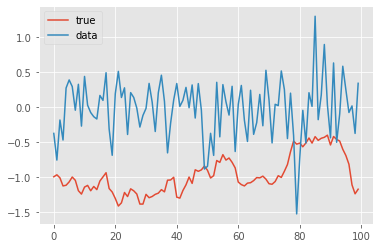

In [3]:
mymodel = StochVol(mu = -1., rho = .9, sigma = .1) # The actual model
true_states, data = mymodel.simulate(100)
plt.style.use("ggplot")
plt.plot(true_states, label = "true")
plt.plot(data, label = "data")
plt.legend()

# Particle filtering

In [4]:
fk_model = ssm.Bootstrap(ssm = mymodel, data = data) #FK model with bootstrap filter
pf = particles.SMC(fk = fk_model, N = 100, resampling = "stratified",
                  collect = [Moments()], store_history = True) # The algorithm
pf.run() # Computation

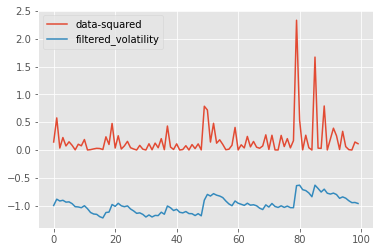

In [6]:
plt.figure()
plt.plot([yt**2 for yt in data], label = "data-squared")
plt.plot([m["mean"] for m in pf.summaries.moments], label = "filtered_volatility")
plt.legend()

# Mutiple runs 
IN order to compare different methods and to compute the variance of the loglikelihood

In [7]:
results = particles.multiSMC(fk = fk_model, N = 100, nruns = 30, qmc = {"SMC": False, "SQMC": True})

/Users/theoalegretti/mambaforge/lib/python3.9/site-packages/particles/rqmc.py:14: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  u = eng.random(N)
/Users/theoalegretti/mambaforge/lib/python3.9/site-packages/particles/rqmc.py:14: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  u = eng.random(N)
/Users/theoalegretti/mambaforge/lib/python3.9/site-packages/particles/rqmc.py:14: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  u = eng.random(N)
/Users/theoalegretti/mambaforge/lib/python3.9/site-packages/particles/rqmc.py:14: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  u = eng.random(N)
/Users/theoalegretti/mambaforge/lib/python3.9/site-packages/particles/rqmc.py:14: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  u = eng.random(N)
/Users/theoalegretti/mambaforge/lib/python3.9/site-packages/particles/rqmc.

In [8]:
# Exemple of how to access the log likelihood 
results[0]["output"]

<AxesSubplot:>

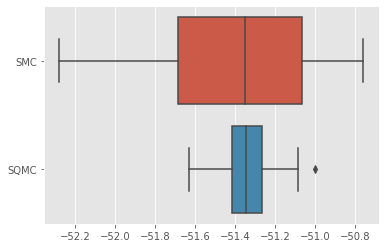

In [9]:
plt.figure()
sb.boxplot(x=[r["output"].logLt for r in results], y = [r["qmc"] for r in results])

# Smoothing

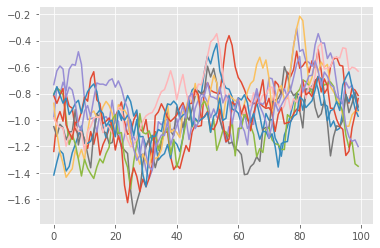

In [10]:
smooth_trajectories = pf.hist.backward_sampling(10)
plt.figure()
plt.plot(smooth_trajectories)